In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # i

In [2]:
import copy

In [3]:
classes=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X','Y')

In [27]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use the first GPU (cuda:0) if available
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: Tesla T4


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd


In [7]:

train_data=pd.read_csv('/content/drive/MyDrive/archive2/archive(2)/sign_mnist_train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/archive2/archive(2)/sign_mnist_test.csv')
train_data.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


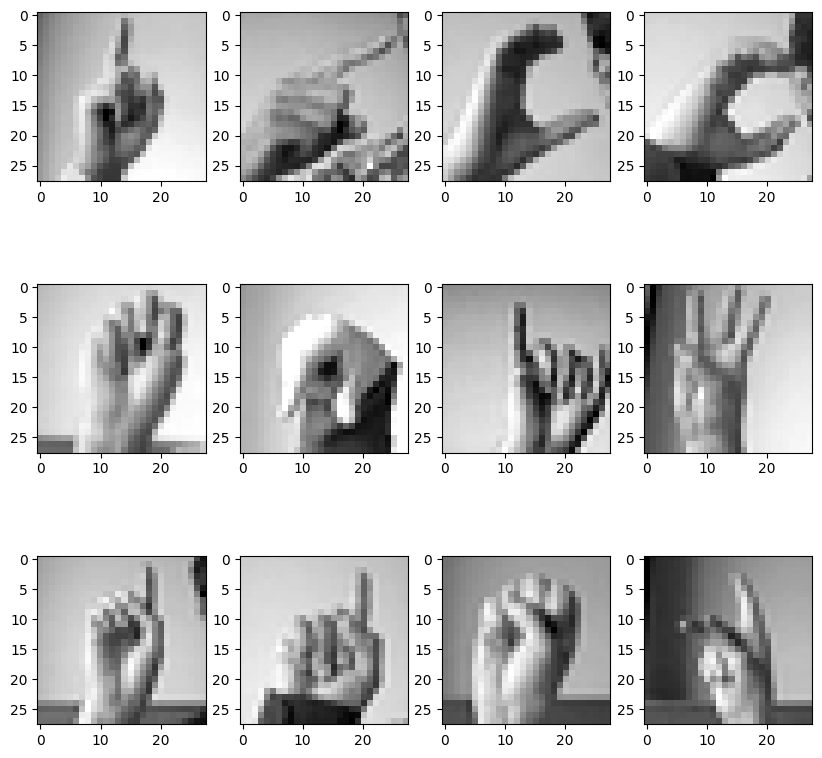

In [30]:
labels = torch.tensor(train_data['label'].values, dtype=torch.long).to(device)

# Prepare the images for processing
text = "pixel"
images = torch.zeros((train_data.shape[0], 1)).to(device)  # Move the tensor to GPU
for i in range(1, 785):
    temp_text = text + str(i)
    temp = torch.tensor(train_data[temp_text].values, dtype=torch.float32).to(device)  # Move the tensor to GPU
    temp = temp.unsqueeze(1)
    images = torch.cat((images, temp), 1)

images_final = images[:, 1:].view(-1, 28, 28)

fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 4
for i in range(12):
    img = images_final[i, :].cpu().numpy()  # Move the tensor back to CPU for visualization
    fig.add_subplot(columns, rows, i + 1)
    plt.imshow(img, cmap='gray')
plt.show()






In [31]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [32]:
class GestureDataset(Dataset):
    def __init__(self,csv,train=True):
        self.csv=pd.read_csv(csv)
        self.img_size=32
        self.train=train
        text="pixel"
        self.images=torch.zeros((self.csv.shape[0],1))
        for i in range(1,785):
            temp_text=text+str(i)
            temp=self.csv[temp_text]
            temp=torch.FloatTensor(temp).unsqueeze(1)
            self.images=torch.cat((self.images,temp),1)
        self.labels=self.csv['label']
        self.images=self.images[:,1:]
        self.images=self.images.view(-1,28,28)

    def __getitem__(self,index):
        img=self.images[index]
        img=img.numpy()
        img=np.resize(img, (self.img_size,self.img_size))
        tensor_image=torch.FloatTensor(img)
        tensor_image=tensor_image.unsqueeze(0)
        tensor_image/=255.
        if self.train:
            return tensor_image,self.labels[index]
        else:
            return tensor_image
    def __len__(self):
        return self.images.shape[0]

In [11]:
data_train=GestureDataset("/content/drive/MyDrive/archive2/archive(2)/sign_mnist_train/sign_mnist_train.csv")
data_val=GestureDataset("/content/drive/MyDrive/archive2/archive(2)/sign_mnist_test/sign_mnist_test.csv")

In [33]:
batch_size=32
train_dl = DataLoader(data_train,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

test_dl = DataLoader(data_val,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [34]:
dataloaders_dict = {"train": train_dl, "val": test_dl}

In [35]:
def train_model(model,dataloaders_dict, criterion, optimizer, scheduler, num_epochs=25, device=device):
      training_loss=[]
      training_accuracy=[]
      val_loss=[]
      val_accuracy=[]
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      model.to(device)

      for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
          if phase == 'train':
            model.train()  # Set model to training mode
          else:
            model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders_dict[phase]:
            #adding noise to my image

            inputs = inputs.to(device)
            labels = labels.to(device)


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
            scheduler.step()

          epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

          if phase=='train':
            training_loss.append(epoch_loss)
            training_accuracy.append(epoch_acc)

          elif phase=='val':
            val_loss.append(epoch_loss)
            val_accuracy.append(epoch_acc)


          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
      return model,training_accuracy,training_loss,val_accuracy,val_loss

In [36]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 25)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
model_ft,train_acc_adam1,train_loss_adam1,val_loss_adam1,val_adam_adam1=train_model(model_ft,dataloaders_dict, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=10, device=device)

Epoch 0/9
----------
train Loss: 0.7811 Acc: 0.7620
val Loss: 0.9905 Acc: 0.7330

Epoch 1/9
----------
train Loss: 0.0642 Acc: 0.9813
val Loss: 0.6375 Acc: 0.8493

Epoch 2/9
----------
train Loss: 0.0221 Acc: 0.9940
val Loss: 0.6759 Acc: 0.8335

Epoch 3/9
----------
train Loss: 0.0163 Acc: 0.9958
val Loss: 0.4177 Acc: 0.8889

Epoch 4/9
----------
train Loss: 0.0143 Acc: 0.9965
val Loss: 0.4836 Acc: 0.8925

Epoch 5/9
----------
train Loss: 0.0092 Acc: 0.9974
val Loss: 0.5167 Acc: 0.8864

Epoch 6/9
----------
train Loss: 0.0052 Acc: 0.9987
val Loss: 0.4427 Acc: 0.8950

Epoch 7/9
----------
train Loss: 0.0036 Acc: 0.9993
val Loss: 0.4061 Acc: 0.9053

Epoch 8/9
----------
train Loss: 0.0025 Acc: 0.9996
val Loss: 0.4006 Acc: 0.9071

Epoch 9/9
----------
train Loss: 0.0022 Acc: 0.9997
val Loss: 0.4196 Acc: 0.8978

Training complete in 2m 24s
Best val Acc: 0.907139


In [40]:
model_ft.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
correct = 0
total = 0


with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to the CUDA device
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f'Accuracy {100 * correct/total} %')

Accuracy 90.7138873396542 %


In [42]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False
model_conv.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 25)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [43]:
model_conv,train_acc_adam1,train_loss_adam1,val_loss_adam1,val_adam_adam1=train_model(model_conv,dataloaders_dict, criterion, optimizer_conv, exp_lr_scheduler,
                        num_epochs=10, device=device)

Epoch 0/9
----------
train Loss: 2.6623 Acc: 0.2205
val Loss: 2.7993 Acc: 0.1889

Epoch 1/9
----------
train Loss: 2.2980 Acc: 0.3205
val Loss: 2.7552 Acc: 0.2168

Epoch 2/9
----------
train Loss: 2.2026 Acc: 0.3464
val Loss: 2.7062 Acc: 0.2260

Epoch 3/9
----------
train Loss: 2.1505 Acc: 0.3573
val Loss: 2.6958 Acc: 0.2308

Epoch 4/9
----------
train Loss: 2.1129 Acc: 0.3693
val Loss: 2.6822 Acc: 0.2404

Epoch 5/9
----------
train Loss: 2.0775 Acc: 0.3785
val Loss: 2.6770 Acc: 0.2458

Epoch 6/9
----------
train Loss: 2.0628 Acc: 0.3841
val Loss: 2.7027 Acc: 0.2341

Epoch 7/9
----------
train Loss: 2.0180 Acc: 0.3987
val Loss: 2.7066 Acc: 0.2421

Epoch 8/9
----------
train Loss: 2.0086 Acc: 0.4011
val Loss: 2.6573 Acc: 0.2501

Epoch 9/9
----------
train Loss: 2.0035 Acc: 0.4038
val Loss: 2.6688 Acc: 0.2454

Training complete in 2m 1s
Best val Acc: 0.250139


In [45]:
model_conv.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  